## Characteristic Reconstruction

In [1]:
from sympy import *
init_printing(use_unicode=True)

### Conserved variables
We start with the Euler equations in conservation-law form, with the vector of conserved variables $U$ and primitive variables $q$. Then we compute the $P$ matrix ($P_{ij} = \partial U_i / \partial q_j$) and the $Q_x$ matrix ($Q_{k,ij} = \partial F_{k,i} / \partial q_j$, where $F_k$ is the flux vector in the $k$ direction) (Sutherland and Kennedy, 2002). ($F$ denotes the fluxes of the conserved variables.)

*See also:* Zingale and Katz (2015).

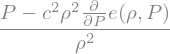

In [2]:
# define symbols
rho = Symbol('rho', positive=True) # density
p = Symbol('P', positive=True) # pressure
u = Symbol('u') # normal velocity
v = Symbol('v') # transverse velocity
w = Symbol('w') # transverse velocity
s = Symbol('s') # passive scalar
c = Symbol('c') # sound speed
e = Function('e')(rho, p) # specific internal energy

E = rho*e + rho*(u**2 + v**2 + w**2)/2 # total energy density

# (this is needed to rewrite the thermodynamic derivatives in terms of the sound speed)
de_drho = solveset(Eq(c**2, (p - rho**2 * Derivative(e, rho)) / (rho**2 * Derivative(e,p))), Derivative(e, rho)).args[0]
de_drho

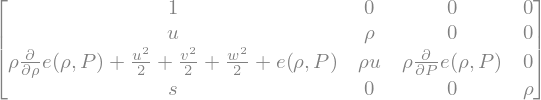

In [3]:
# compute the P matrix from Sutherland and Kennedy (2003)
U = Matrix([rho, rho*u, E, rho*s])
q = Matrix([rho, u, p, s])
P = simplify(Matrix(BlockMatrix(Derivative(U, q, evaluate=True).T)).T)
P

In [4]:
# compute the Q_n matrix
F_n = Matrix([rho*u,  # flux vector in normal direction
            rho*u**2 + p,
            (E + p)*u,
            rho*u*s])
Q_n = simplify(Matrix(BlockMatrix(Derivative(F_n, q, evaluate=True).T)).T)

### Primitive variables
Now we compute the coefficient matrix $A_x$ for the primitive equations ($A = P^{-1} Q$):

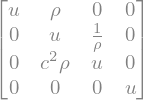

In [5]:
# compute the A_n matrix from Sutherland and Kennedy (2003)
# (this is the primitive variable flux matrix in the normal direction)
A_n = simplify(Inverse(P) * Q_n).subs(Derivative(e,rho), de_drho)
A_n

### Characteristic variables
We compute the eigenvalues $\lambda$ and eigenvectors $S$ of the $A_x$ matrix.

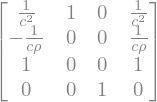

In [6]:
# compute the eigenvector matrix S
c = Symbol('c')
rho = Symbol('rho')
lambda_list = [eval for (eval, n, es) in A_n.eigenvects()]
R_list = [[ev for ev in es] for (v, n, es) in A_n.eigenvects()]
R = Matrix([[R_list[1][0].T],
               [R_list[0][0].T],
               [R_list[0][1].T],
               [R_list[2][0].T]]).T
R

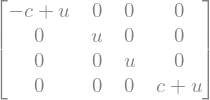

In [7]:
# compute eigenvalue matrix \lambda
Lambda = diag(lambda_list[1], lambda_list[0], lambda_list[0], lambda_list[2])
Lambda

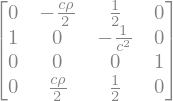

In [8]:
L = R.inv()
L

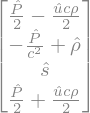

In [9]:
# compute L*q
q0 = Symbol(r'\hat \rho')
q1 = Symbol(r'\hat u')
q2 = Symbol(r'\hat P')
q3 = Symbol(r'\hat s')
q = Matrix([q0, q1, q2, q3])
qp = simplify(L*q)
qp

In [10]:
q0 = Symbol(r'rho_hat')
q1 = Symbol(r'u_hat')
q2 = Symbol(r'P_hat')
q3 = Symbol(r's_hat')
q = Matrix([q0, q1, q2, q3])
qp = simplify(L*q)

common_exprs_lower, final_expr_lower = cse(qp, list=False)
for var, val in common_exprs_lower:
    print(cxxcode(val, assign_to=var))
print(cxxcode(final_expr_lower, assign_to='charVars'))

x0 = (1.0/2.0)*P_hat;
x1 = (1.0/2.0)*c*rho*u_hat;
charVars[0] = x0 - x1;
charVars[1] = -P_hat/std::pow(c, 2) + rho_hat;
charVars[2] = s_hat;
charVars[3] = x0 + x1;


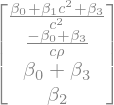

In [11]:
r0 = Symbol(r'\beta_0')
r1 = Symbol(r'\beta_1')
r2 = Symbol(r'\beta_2')
r3 = Symbol(r'\beta_3')
r = Matrix([r0, r1, r2, r3])
rp = simplify(R*r)
rp

In [12]:
r0 = Symbol(r'beta_0')
r1 = Symbol(r'beta_1')
r2 = Symbol(r'beta_2')
r3 = Symbol(r'beta_3')
r = Matrix([r0, r1, r2, r3])
rp = simplify(R*r)
common_exprs_lower, final_expr_lower = cse(rp, list=False)
for var, val in common_exprs_lower:
    print(cxxcode(val, assign_to=var))
print(cxxcode(final_expr_lower, assign_to='primVars'))

x0 = std::pow(c, 2);
x1 = beta_0 + beta_3;
primVars[0] = (beta_1*x0 + x1)/x0;
primVars[1] = (-beta_0 + beta_3)/(c*rho);
primVars[2] = x1;
primVars[3] = beta_2;


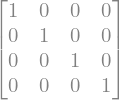

In [13]:
simplify(R*L)

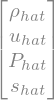

In [14]:
simplify(R*qp)